# causalnex trial 01

NOTEARSを用いた因果グラフ推定、ベイジアンネットの推定。
- from_pandas
- BayesianNetwork

# 必要パッケージ インストール & import

In [1]:
!pip install causalnex
!pip install networkx
!pip install pgmpy
from IPython.display import clear_output
clear_output()

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx
import warnings; warnings.simplefilter("ignore")
%matplotlib inline

In [3]:
# import causalnex
from causalnex.structure.notears import from_pandas #, from_pandas_lasso
#from causalnex.structure.pytorch import from_pandas as from_pandas_pytorch

from causalnex.network import BayesianNetwork
from causalnex.discretiser import Discretiser
# from causalnex.structure import DAGClassifier, DAGRegressor

In [4]:
# networkx_util
from util.networkx_util import NetworkxUtil
nx_util = NetworkxUtil() # networkxの図示, printのためのutil

# サンプルデータ作成

In [5]:
def generate_sample_data(n_samples=1000):
    """
    サンプルデータ生成
    | c1 --> x1
    | c2 --> x1
    | c1 --> y
    | c2 --> y
    | x1 --> y
    | x2 は独立
    """
    np.random.seed(0)
    c1 = np.random.normal(0, 0.5, size=n_samples)
    c2 = np.random.choice(2, size=n_samples)

    np.random.seed(1)
    x1 = np.random.normal(1, 2, size=n_samples) + c1 + c2/10

    np.random.seed(2)
    y = np.random.uniform(-1,2, size=n_samples) + x1 + c1 + c2 /10

    np.random.seed(3)
    x2 = np.random.uniform(-2, 2, size=n_samples)
    raw_data = pd.DataFrame({"x1": x1, "y":y, "x2": x2, "c1": c1, "c2":c2})
    return raw_data

In [6]:
n_samples = 2000
struct_data = generate_sample_data(n_samples)
print(struct_data.shape)

(2000, 5)


## NO TEARSで因果グラフ推定

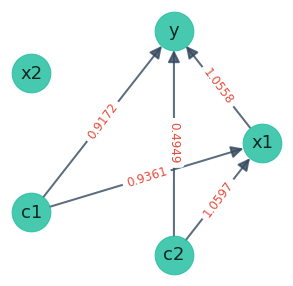

In [7]:
# NOTEARSを実行, from_pandas_lassoでL1 penaltyをつけて推定することが可能
sm = from_pandas( 
    struct_data,
    tabu_edges = [],
    tabu_parent_nodes = None,
    tabu_child_nodes = None,
)
sm.threshold_till_dag() # DAGになるように閾値をあげる
sm.remove_edges_below_threshold(0.2) # 係数の閾値を0.2にする
nx_util.plot_structure_model(structure_model=sm, layout_method="circular") # この条件で正しく推定できていることがわかる。

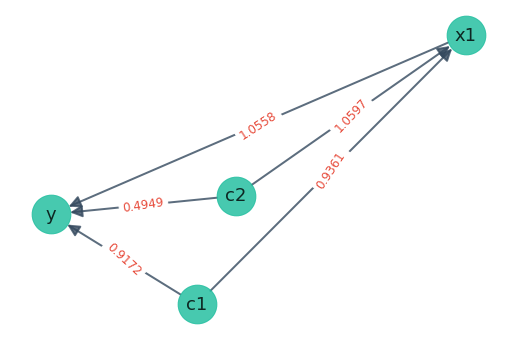

In [8]:
# largest subgraphを抽出
sm = sm.get_largest_subgraph()
nx_util.plot_structure_model(sm, layout_method="random", figsize=(9,6))

In [9]:
# 係数をprint
nx_util.print_weights(sm)

[ x1 ] ---> [ y ]		Weight	1.05582
[ c1 ] ---> [ x1 ]		Weight	0.93608
[ c1 ] ---> [ y ]		Weight	0.91724
[ c2 ] ---> [ x1 ]		Weight	1.05973
[ c2 ] ---> [ y ]		Weight	0.49489


## NO TEARSでTabuを指定して因果グラフを推定

[ y ] ---> [ x1 ]		Weight	0.75815
[ y ] ---> [ c2 ]		Weight	0.22665
[ c1 ] ---> [ c2 ]		Weight	-0.32098


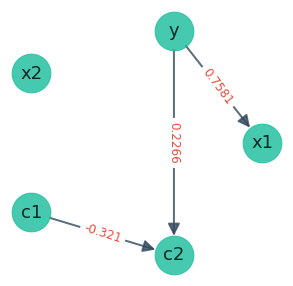

In [10]:
# struct data
sm_with_tabu = from_pandas(
    struct_data,
    tabu_edges = [("c1", "x1")], # c1 --> x1 に線が引かれなくなる。
    tabu_parent_nodes = ["c2"], # 親ノードにならなくなる。矢印元にならなくなる。
    tabu_child_nodes = ["y"], # 子ノードにならなくなる。矢印が刺されなくなる。
)
sm_with_tabu.threshold_till_dag()
sm_with_tabu.remove_edges_below_threshold(0.2)

nx_util.plot_structure_model(structure_model=sm_with_tabu, layout_method="circular") # 
nx_util.print_weights(sm_with_tabu) # 係数を print

## NO TEARSで推定した因果グラフから、ベイジアンネットを推定

In [11]:
# ベイジアンネットを推定するために離散化
discretised_data = struct_data.copy().drop(["x2"], axis=1)
discretised_data["y"] = Discretiser(method="quantile", num_buckets=5).fit_transform(discretised_data["y"].values)
discretised_data["x1"] = Discretiser(method="uniform", num_buckets=5).fit_transform(discretised_data["x1"].values)
discretised_data["c1"] = Discretiser(method="percentiles", percentile_split_points=[0.25, 0.5, 0.75]).fit_transform(discretised_data["c1"].values)
discretised_data["c2"] = Discretiser(method="fixed", numeric_split_points=[0,1]).transform(discretised_data["c2"].values)

In [12]:
# load estimated causal graph
bn = BayesianNetwork(sm)

bn = bn.fit_node_states(discretised_data) # 取りうるすべての状態を指定、 本来testデータに新出のカテゴリがある場合には判定し、変換する必要がある
bn = bn.fit_cpds(discretised_data, method="BayesianEstimator", bayes_prior="K2")

In [13]:
# 条件付き確率を推定
bn.cpds["y"]

c1         0                                                               \
c2         1                                        2                       
x1         0         1         2         3    4     0         1         2   
y                                                                           
0   0.777778  0.701923  0.068966  0.043478  0.2  0.80  0.683168  0.060606   
1   0.055556  0.211538  0.275862  0.043478  0.2  0.05  0.217822  0.303030   
2   0.055556  0.067308  0.439655  0.043478  0.2  0.05  0.079208  0.325758   
3   0.055556  0.009615  0.181034  0.391304  0.2  0.05  0.009901  0.250000   
4   0.055556  0.009615  0.034483  0.478261  0.2  0.05  0.009901  0.060606   

c1                 ...         3                                          \
c2                 ...         1                                           
x1         3    4  ...         0         1         2         3         4   
y                  ...                                                     
0   0.038462  0.2  ...  0.428571  0.328125  0.007519  0.014925  0.142857   
1   0.038462  0.2  ...  0.142857  0.343750  0.097744  0.014925  0.142857   
2   0.038462  0.2  ...  0.142857  0.250000  0.180451  0.014925  0.142857   
3   0.307692  0.2  ...  0.142857  0.062500  0.413534  0.104478  0.142857   
4   0.576923  0.2  ...  0.142857  0.015625  0.300752  0.850746  0.428571   

c1                                                    
c2         2                                          
x1         0         1         2         3         4  
y                                                     
0   0.714286  0.262295  0.007299  0.019608  0.111111  
1   0.071429  0.377049  0.094891  0.019608  0.111111  
2   0.071429  0.278689  0.182482  0.019608  0.111111  
3   0.071429  0.065574  0.437956  0.058824  0.111111  
4   0.071429  0.016393  0.277372  0.882353  0.555556  

[5 rows x 40 columns]

## 推定したモデルから予測値を算出

In [14]:
pred_target_col = "y"
parents_columns = bn.cpds[pred_target_col].columns.names # 予測対象カラムの親ノードのみ必要であるためsliceする、sliceせずとも実行可能
y_pred = bn.predict(discretised_data[parents_columns], pred_target_col)
y_predict_proba = bn.predict_probability(discretised_data[parents_columns], pred_target_col) # 予測確率

In [15]:
# 実測値
discretised_data["y"].head(5)

0    4
1    0
2    2
3    2
4    4
Name: y, dtype: int64

In [16]:
# 予測値
y_pred.head(5)

,y_prediction
0,4
1,1
2,3
3,1
4,4


In [17]:
# 予測確率
y_predict_proba.head(5)

,y_0,y_1,y_2,y_3,y_4
0,0.019608,0.019608,0.019608,0.058824,0.882353
1,0.350649,0.428571,0.181818,0.025974,0.012987
2,0.007519,0.097744,0.180451,0.413534,0.300752
3,0.262295,0.377049,0.278689,0.065574,0.016393
4,0.014925,0.014925,0.014925,0.104478,0.850746
